# **Wind Energy Analysis And Prediction**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
data = pd.read_excel('/ANN Project Dataset 1.xlsx',index_col="DateTime")
data

,Pressure | (atm),Wind direction | (deg),Wind speed | (m/s),Power generated by system | (kW)
DateTime,,,,
2007-01-01 00:00:00,0.890467,104,3.429,0.00
2007-01-01 01:00:00,0.890583,106,3.579,0.00
2007-01-01 02:00:00,0.890366,102,4.307,1986.68
2007-01-01 03:00:00,0.890326,99,4.562,2597.61
2007-01-01 04:00:00,0.890549,98,4.553,2555.46
...,...,...,...,...
2007-12-31 19:00:00,0.897633,120,2.357,0.00
2007-12-31 20:00:00,0.897476,103,3.446,0.00
2007-12-31 21:00:00,0.897044,102,4.938,3818.08


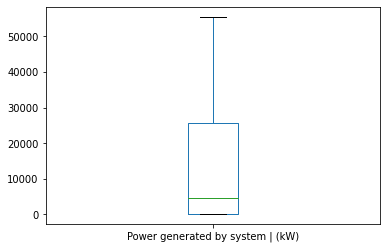

In [3]:
data.boxplot(column =['Power generated by system | (kW)'], grid = False)

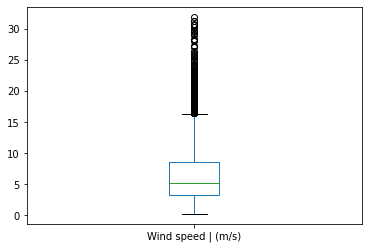

In [24]:
data.boxplot(column =['Wind speed | (m/s)'], grid = False)

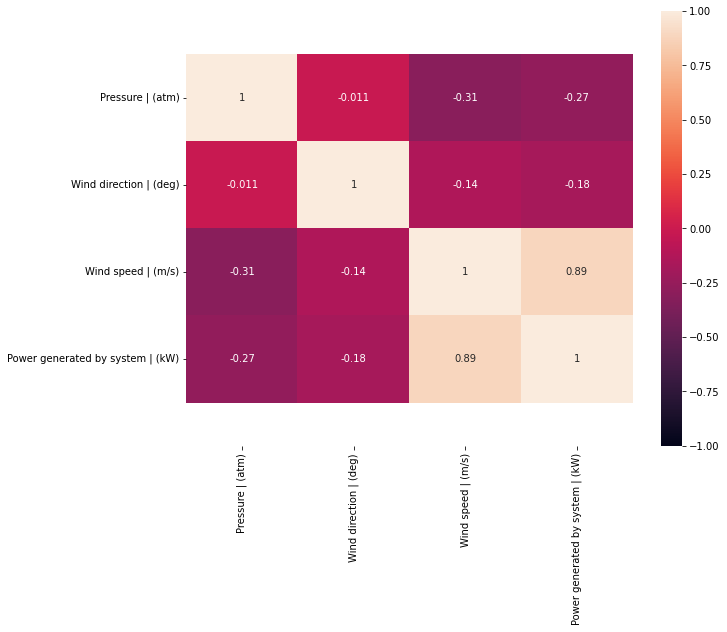

,Pressure | (atm),Wind direction | (deg),Wind speed | (m/s),Power generated by system | (kW)
Pressure | (atm),1.000000,-0.011350,-0.306283,-0.272508
Wind direction | (deg),-0.011350,1.000000,-0.135963,-0.178607
Wind speed | (m/s),-0.306283,-0.135963,1.000000,0.890219
Power generated by system | (kW),-0.272508,-0.178607,0.890219,1.000000


In [4]:
corr = data.corr()
plt.figure(figsize=(10, 8))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
corr

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2007-01-01 00:00:00 to 2007-12-31 23:00:00
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Pressure | (atm)                  8760 non-null   float64
 1   Wind direction | (deg)            8760 non-null   int64  
 2   Wind speed | (m/s)                8760 non-null   float64
 3   Power generated by system | (kW)  8760 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 342.2 KB


In [6]:
data.describe()

,Pressure | (atm),Wind direction | (deg),Wind speed | (m/s),Power generated by system | (kW)
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.884977,228.458219,6.308794,14803.923135
std,0.005786,81.872038,4.221430,18801.398577
min,0.865102,0.000000,0.169000,0.000000
25%,0.882163,137.000000,3.288750,0.000000
50%,0.885612,252.000000,5.239000,4676.360000
75%,0.888562,294.000000,8.537250,25765.400000
max,0.899212,360.000000,31.950000,55485.700000


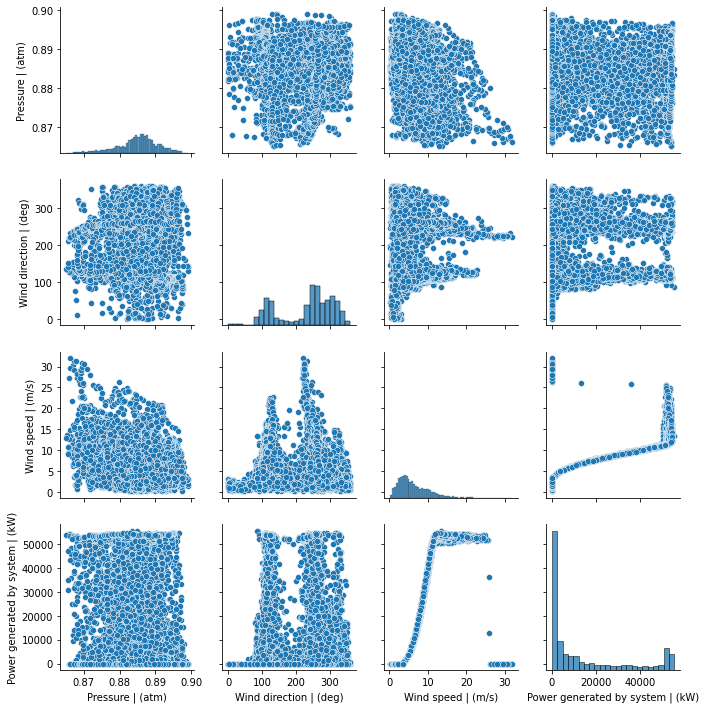

In [7]:
sns.pairplot(data)

In [8]:
del data['Pressure | (atm)']
#del data['Wind speed | (m/s)']
del data['Wind direction | (deg)']
del data['Power generated by system | (kW)']
data.head()

,Wind speed | (m/s)
DateTime,
2007-01-01 00:00:00,3.429
2007-01-01 01:00:00,3.579
2007-01-01 02:00:00,4.307
2007-01-01 03:00:00,4.562
2007-01-01 04:00:00,4.553


In [9]:
dataset = data.values
train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:] 
test= dataset[train_size:len(dataset),:]

In [10]:
def create_dataset(dataset, timestep=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - timestep):
        a = dataset[i:(i + timestep), 0]
        dataX.append(a)
        dataY.append(dataset[i + timestep, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
timestep= 8
trainX, trainY = create_dataset(train, timestep)
testX, testY = create_dataset(test, timestep)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

In [13]:
trainX.shape

(5248, 8, 1)

In [14]:
testX.shape

(3496, 8, 1)

In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [16]:
result = model.predict(testX)

110/110 [==============================] - 1s 4ms/step


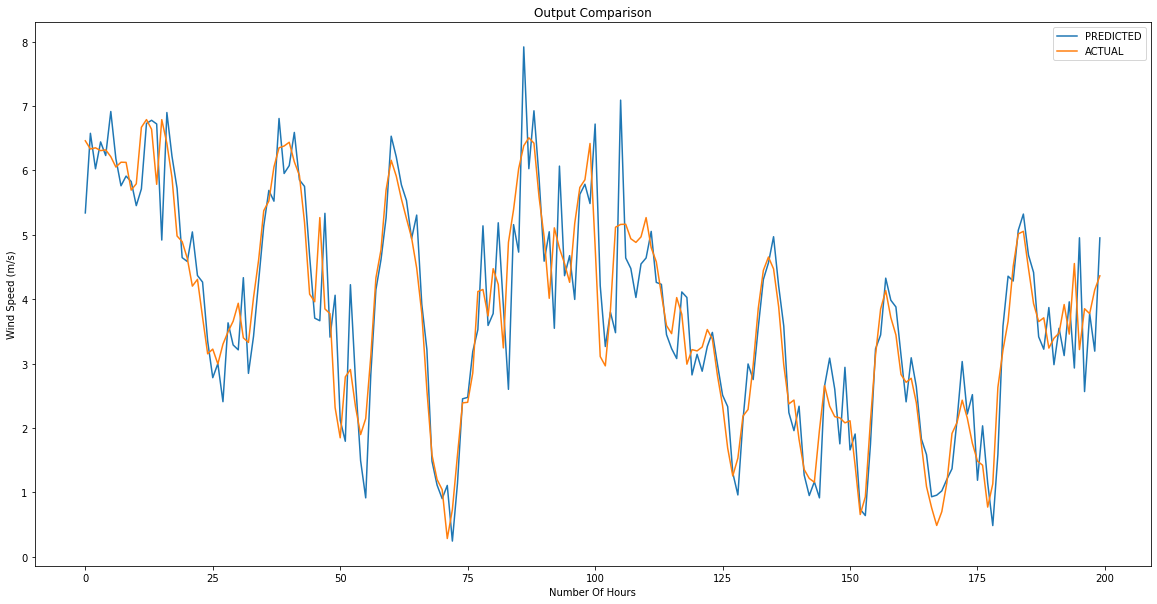

In [17]:
plt.figure(figsize=(20,10))
plt.plot(result[:200], label='PREDICTED')
plt.plot(testY[:200], label='ACTUAL')
plt.title("Output Comparison")
plt.xlabel("Number Of Hours")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.show()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


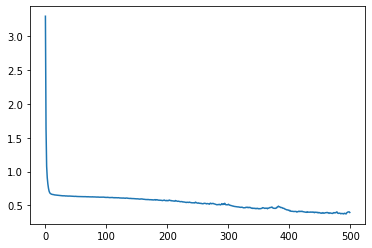

In [19]:
plt.plot(history.history['loss'])
plt.show()

In [20]:
print("Mean squared error: %.3f" % mean_squared_error(testY, result))

Mean squared error: 1.551


In [21]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, result)))

Root mean squared error: 1.246


In [22]:
 print("Variance : %.3f" % r2_score(testY, result))

Variance : 0.927
